## TRABAJO ACADÉMICO: EVALUACIÓN DE ETIQUETADORES MORFOSINTÁCTICOS PARA EL ESPAÑOL

###### Anna Llinares Llinares

#### Importación de librerías

In [1]:
import nltk 

from math import sqrt
import statistics
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.tag import hmm
from nltk.tag import tnt, AffixTagger, brill, brill_trainer, CRFTagger, UnigramTagger, BigramTagger
from nltk.tag.perceptron import PerceptronTagger

import numpy as np 
from sklearn.model_selection import KFold 

import random

import spacy
import stanza

import re

#### Carga del corpus

In [2]:
from nltk.corpus import cess_esp

#### Funciones auxiliares 

In [3]:
corpus_sentences=cess_esp.tagged_sents() # extraemos las oraciones etiquetadas
number_sentences=len(corpus_sentences)
print ('Número de frases:',number_sentences)
nw=0;
for s in range (len(corpus_sentences)):
    nw=nw+len(corpus_sentences[s])

print ('Número de palabras:',nw)

print(corpus_sentences[0:2]) # muestro las 2 primeras oraciones del corpus etiquetado
completed_corpus = corpus_sentences

Número de frases: 6030
Número de palabras: 192686
[[('El', 'da0ms0'), ('grupo', 'ncms000'), ('estatal', 'aq0cs0'), ('Electricité_de_France', 'np00000'), ('-Fpa-', 'Fpa'), ('EDF', 'np00000'), ('-Fpt-', 'Fpt'), ('anunció', 'vmis3s0'), ('hoy', 'rg'), (',', 'Fc'), ('jueves', 'W'), (',', 'Fc'), ('la', 'da0fs0'), ('compra', 'ncfs000'), ('del', 'spcms'), ('51_por_ciento', 'Zp'), ('de', 'sps00'), ('la', 'da0fs0'), ('empresa', 'ncfs000'), ('mexicana', 'aq0fs0'), ('Electricidad_Águila_de_Altamira', 'np00000'), ('-Fpa-', 'Fpa'), ('EAA', 'np00000'), ('-Fpt-', 'Fpt'), (',', 'Fc'), ('creada', 'aq0fsp'), ('por', 'sps00'), ('el', 'da0ms0'), ('japonés', 'aq0ms0'), ('Mitsubishi_Corporation', 'np00000'), ('para', 'sps00'), ('poner_en_marcha', 'vmn0000'), ('una', 'di0fs0'), ('central', 'ncfs000'), ('de', 'sps00'), ('gas', 'ncms000'), ('de', 'sps00'), ('495', 'Z'), ('megavatios', 'ncmp000'), ('.', 'Fp')], [('Una', 'di0fs0'), ('portavoz', 'nccs000'), ('de', 'sps00'), ('EDF', 'np00000'), ('explicó', 'vmis3s0

In [4]:
def rename(x):
    if x.startswith("v") or x.startswith("F"): #Si la etiqueta es de un verbo o signo de
        return x[:min(len(x),3)] #longitud máxima puede ser 3
    
    else: #Cualquier otra etiqueta long max
        return x[:min(len(x),2)] # por defecto, para lo demás la long máx es 2

In [5]:
reduced_corpus=[]
for sentence in corpus_sentences:
    newsent=[(x[0], rename(x[1])) for x in sentence if not(x[1] in (u'*0*',u'sn'))] # elimino este tipo de etiquetas porque directamente las omito
    reduced_corpus.append(newsent)

In [6]:
print(reduced_corpus[:20])

[[('El', 'da'), ('grupo', 'nc'), ('estatal', 'aq'), ('Electricité_de_France', 'np'), ('-Fpa-', 'Fpa'), ('EDF', 'np'), ('-Fpt-', 'Fpt'), ('anunció', 'vmi'), ('hoy', 'rg'), (',', 'Fc'), ('jueves', 'W'), (',', 'Fc'), ('la', 'da'), ('compra', 'nc'), ('del', 'sp'), ('51_por_ciento', 'Zp'), ('de', 'sp'), ('la', 'da'), ('empresa', 'nc'), ('mexicana', 'aq'), ('Electricidad_Águila_de_Altamira', 'np'), ('-Fpa-', 'Fpa'), ('EAA', 'np'), ('-Fpt-', 'Fpt'), (',', 'Fc'), ('creada', 'aq'), ('por', 'sp'), ('el', 'da'), ('japonés', 'aq'), ('Mitsubishi_Corporation', 'np'), ('para', 'sp'), ('poner_en_marcha', 'vmn'), ('una', 'di'), ('central', 'nc'), ('de', 'sp'), ('gas', 'nc'), ('de', 'sp'), ('495', 'Z'), ('megavatios', 'nc'), ('.', 'Fp')], [('Una', 'di'), ('portavoz', 'nc'), ('de', 'sp'), ('EDF', 'np'), ('explicó', 'vmi'), ('a', 'sp'), ('EFE', 'np'), ('que', 'cs'), ('el', 'da'), ('proyecto', 'nc'), ('para', 'sp'), ('la', 'da'), ('construcción', 'nc'), ('de', 'sp'), ('Altamira_2', 'np'), (',', 'Fc'), ('al

In [7]:
def ic(N,acc):
    
    return 1.96*sqrt(acc*(1-acc)/N)

In [8]:
def hmm_model(train,test): 
    tagger_hmm=hmm.HiddenMarkovModelTagger.train(train) # le pasamos la lista de listas para entrenar
    acc=tagger_hmm.accuracy(test)

    return acc

In [9]:
def tnt_model(trai,test): 
    tagger_tnt = tnt.TnT()
    tagger_tnt.train(train)  
    acc = tagger_tnt.evaluate(test)
    return acc

### Tarea 1: Evaluación del etiquetador ‘hmm’ sobre el corpus ‘cess-esp’ utilizando el juego de  categorías completo y reducido.

Utilizando el etiquetador hmm basado en modelos de Markov, se realizará una validación cruzada 
sobre 10 particiones del corpus. Barajar el corpus antes de realizar las particiones. Presentar los 
resultados en forma de tabla y gráficamente, incluyendo los intervalos de confianza.

In [10]:
def KFold_hmm(data, folds, s=True):
    newsentences=np.asarray(data) 
    kf=KFold(n_splits=folds, shuffle=s) # shuffle default=True --> barajo
    scores=[]
    longitudes=[]
    for train_index, test_index in kf.split(newsentences): 
        x_train,x_test = newsentences[train_index],newsentences[test_index]  
        longitudes.append(len(x_test))
        tagger_hmm=hmm.HiddenMarkovModelTagger.train(x_train)  
        result=tagger_hmm.accuracy(x_test) 
        scores.append(result)
       
    return scores,longitudes

In [11]:
s, l=KFold_hmm(reduced_corpus, 10)
acc_reduced = [i for i in s]
ic95_reduced=[ic(l[i],acc_reduced[i]) for i in range(0,len(l))]

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\540525373.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


In [12]:
s, l=KFold_hmm(completed_corpus, 10)
acc_completed = [i for i in s]
ic95_completed=[ic(l[i],acc_completed[i]) for i in range(0,len(l))]

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\540525373.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


In [13]:
tabla = pd.DataFrame({'Fold': [1,2,3,4,5,6,7,8,9,10],
    'Accuracy corpus reducido': acc_reduced,
                      'IC corpus reducido': ic95_reduced,
                      'Accuracy corpus completo': acc_completed,
                      'IC corpus completo': ic95_completed})
tabla

,Fold,Accuracy corpus reducido,IC corpus reducido,Accuracy corpus completo,IC corpus completo
0,1,0.931670,0.020139,0.899475,0.024001
1,2,0.930591,0.020285,0.892022,0.024772
2,3,0.925915,0.020905,0.892482,0.024725
3,4,0.930116,0.020350,0.894135,0.024557
4,5,0.921426,0.021477,0.894915,0.024477
5,6,0.931777,0.020124,0.899028,0.024048
6,7,0.929356,0.020452,0.897357,0.024224
7,8,0.930018,0.020363,0.898933,0.024058
8,9,0.932610,0.020010,0.898982,0.024053
9,10,0.929455,0.020438,0.899333,0.024016


In [14]:
def hmm_chart(folds,s, text='for reduced corpus',min=0.825):
    x=[i for i in range(folds)] 
    y,longitudes=s
    ic95=[ic(l[i],y[i]) for i in range(0,len(longitudes))]
    plt.axis([-1,10, min, 1])#([-1,10, min(scores)-0.1, max(scores)+0.1]) 
    plt.ylabel('Accuracy') 
    plt.xlabel('Fold') 
    plt.title(f'{folds}-fold cross validation {text}')
    plt.errorbar(x,y,yerr=ic95,linestyle='None')
    plt.plot(x,y,'ro') 
    plt.show()

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\540525373.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


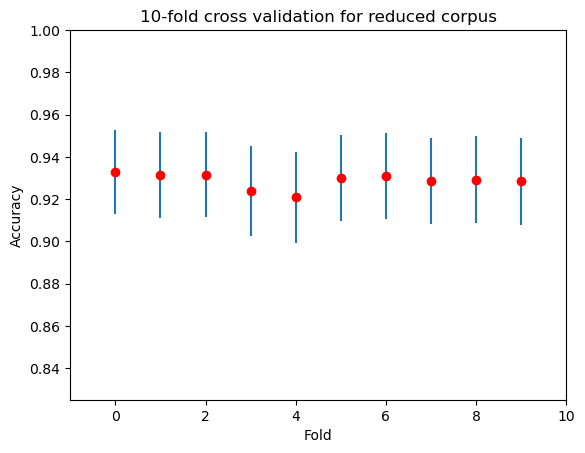

In [15]:
hmm_chart(10,KFold_hmm(reduced_corpus, 10))

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\540525373.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


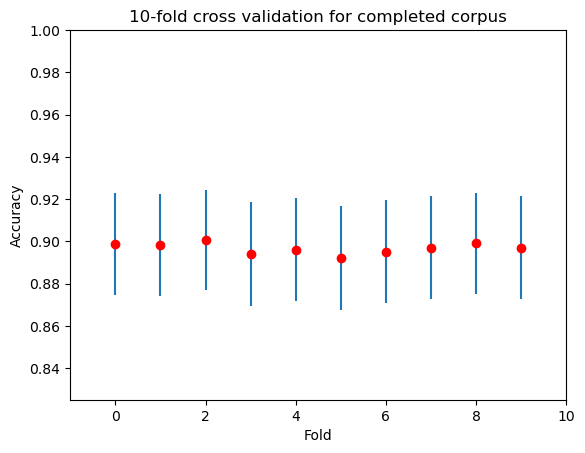

In [16]:
hmm_chart(10, KFold_hmm(completed_corpus, 10), text= 'for completed corpus')

### Tarea 2: Evaluación de las prestaciones del etiquetador respecto a la cantidad de datos de aprendizaje.

Se trata de estudiar cómo varían las prestaciones del etiquetador hmm cuando varía el tamaño del
corpus de aprendizaje. Para este experimento se dividirá el corpus de entrenamiento en 10 partes
de tamaño similar. La partición 10 se tomará como test, y las 9 particiones restantes se tomarán
como entrenamiento. En cada ejecución, se irá incrementando sucesivamente el tamaño del corpus
de entrenamiento, manteniendo fija la partición de test.

**Importante**: Para esta tarea no es necesario realizar la validación cruzada. 

In [17]:
def hmm_data_progresivo(data, parts, s=True):
    newsentences=np.asarray(data) 
    random.shuffle(newsentences)
    partitions = np.array_split(newsentences, parts) #partición del corpus en 10
    scores=[]
    longitudes=[]
    p=partitions[0]
    for i in range(0,parts-1): 
        x_train,x_test = p,partitions[-1]  
        longitudes.append(len(x_test))
        tagger_hmm=hmm.HiddenMarkovModelTagger.train(x_train)  
        result=tagger_hmm.accuracy(x_test) 
        scores.append(result)
        p+=partitions[i+1]
       
    return scores,longitudes

In [18]:
s, l=hmm_data_progresivo(reduced_corpus, 10)
acc_reduced = [i for i in s]
ic95_reduced=[ic(l[i],acc_reduced[i]) for i in range(0,len(l))]

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1361367424.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


In [19]:
s, l=hmm_data_progresivo(completed_corpus, 10)
acc_completed = [i for i in s]
ic95_completed=[ic(l[i],acc_completed[i]) for i in range(0,len(l))]

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1361367424.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


In [20]:
tabla = pd.DataFrame({'Nº particiones': [1,2,3,4,5,6,7,8,9],
    'Accuracy corpus reducido': acc_reduced,
                      'IC corpus reducido': ic95_reduced,
                      'Accuracy corpus completo': acc_completed,
                      'IC corpus completo': ic95_completed})
tabla

,Nº particiones,Accuracy corpus reducido,IC corpus reducido,Accuracy corpus completo,IC corpus completo
0,1,0.839521,0.029297,0.786124,0.032728
1,2,0.870321,0.026815,0.831033,0.029909
2,3,0.888271,0.025145,0.852532,0.028301
3,4,0.899694,0.023978,0.865007,0.027275
4,5,0.908363,0.023028,0.874137,0.026475
5,6,0.913463,0.022441,0.883321,0.025624
6,7,0.919021,0.021774,0.889585,0.025015
7,8,0.923049,0.021272,0.894522,0.024517
8,9,0.927231,0.020733,0.896698,0.024293


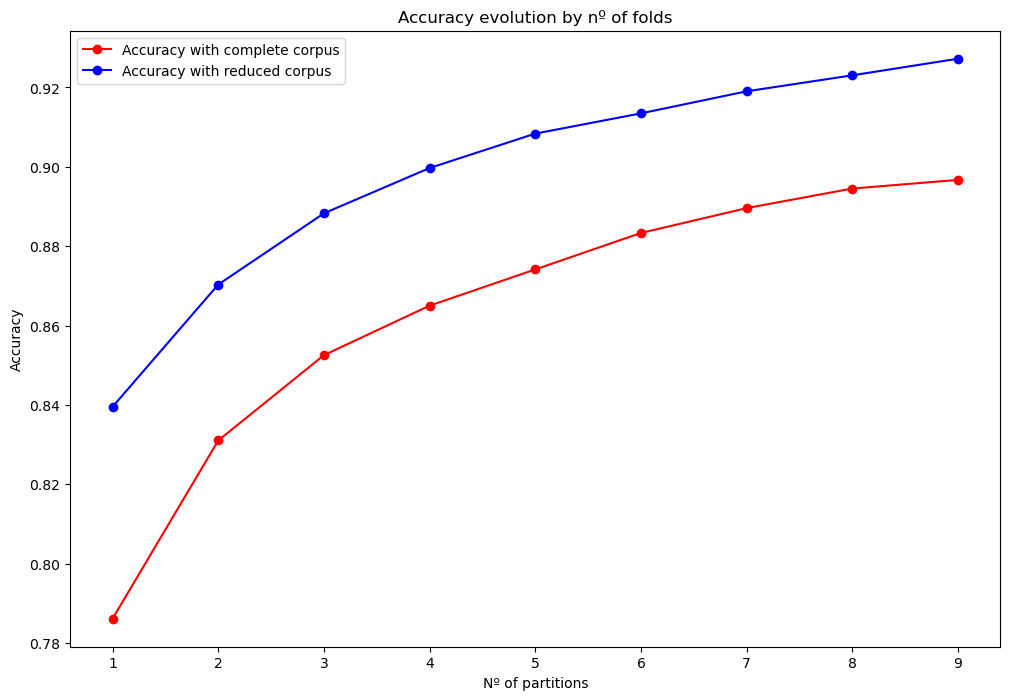

In [21]:
x = [i for i in range(1,10)]
plt.figure(figsize=(12, 8)) 
plt.plot(x, acc_completed, 'ro-', label='Accuracy with complete corpus')
plt.plot(x, acc_reduced, 'bo-', label='Accuracy with reduced corpus')
plt.title('Accuracy evolution by nº of folds')
plt.xlabel('Nº of partitions')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
def hmm_partitioned_chart(partitions,s, text='for reduced corpus'):
    x=[i for i in range(1,partitions)] 
    y,longitudes=s
    ic95=[ic(l[i],y[i]) for i in range(0,len(longitudes))]
    plt.axis([-1,10, 0.70, 1])#([-1,10, min(scores)-0.1, max(scores)+0.1]) 
    plt.ylabel('Accuracy') 
    plt.xlabel('Fold') 
    plt.title(f'{partitions} partitions {text}')
    plt.errorbar(x,y,yerr=ic95,linestyle='None')
    plt.plot(x,y,'ro') 
    plt.show()

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1361367424.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


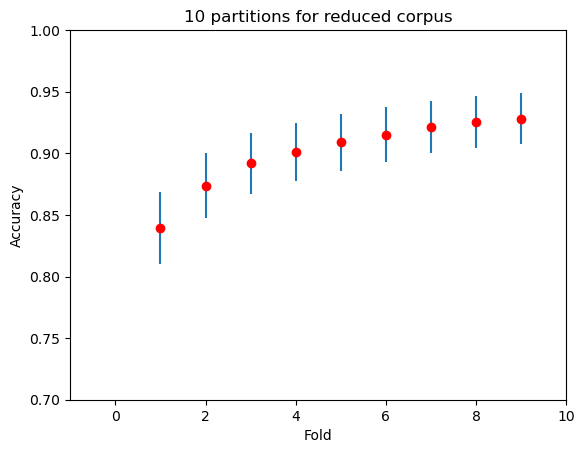

In [23]:
hmm_partitioned_chart(10,hmm_data_progresivo(reduced_corpus, 10))

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1361367424.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


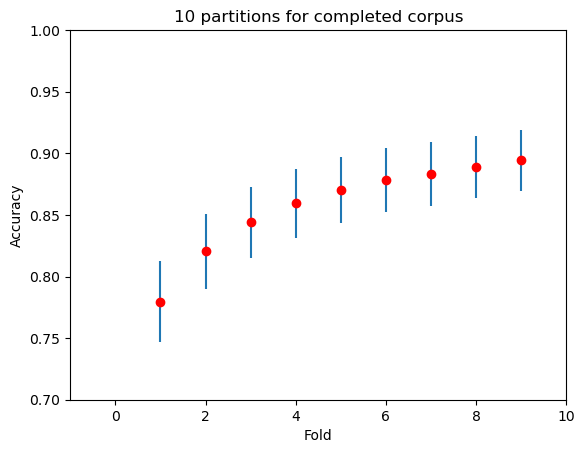

In [24]:
hmm_partitioned_chart(10,hmm_data_progresivo(completed_corpus, 10),text= 'for completed corpus')

### Tarea 3: Evaluación del método de suavizado para palabras desconocidas para el etiquetador tnt.

El etiquetador tnt por defecto no incorpora un método de suavizado para las palabras desconocidas.
Utiliza un método basado en los sufijos de las palabras para construir un modelo para las palabras
desconocidas (Affix Tagger). En base al sufijo de la palabra desconocida le asigna una categoría
morfosintáctica. Este método funciona razonablemente bien para el inglés.
En concreto, se trata de estudiar diferentes longitudes del sufijo (número de letras que se tienen en
cuenta) y estudiar cómo varían las prestaciones del etiquetador. Una vez se haya decidido el sufijo
que mejores prestaciones proporciona, incorporarlo como modelo de suavizado al etiquetador tnt y
comprobar si aumenta sus prestaciones.

In [25]:
def sufixes_kfold_accuracy(folds, data, s=True):
    newsentences=np.asarray(data) 
    
    sufixes=[1,2,3,4,5,6]   
    kf=KFold(n_splits=folds, shuffle=s) # shuffle default=True --> barajo
    accuracy_sufixes=[]
    
    for sufix in sufixes:
        accuracy_model=[]

        for train_index, test_index in kf.split(newsentences): 
            x_train = newsentences[train_index]
            x_test=newsentences[test_index]
            
            affix_tagger = AffixTagger(train=[i for i in x_train], affix_length = -sufix)

            acc = affix_tagger.accuracy(x_test)
            accuracy_model.append(acc)
        accuracy_sufixes.append(accuracy_model)
    return accuracy_sufixes 


In [26]:
acc_reduced=sufixes_kfold_accuracy(10,reduced_corpus)
[statistics.mean(acc) for acc in acc_reduced]

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\3094584275.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


[0.25938620218648006,
 0.27687892021511185,
 0.28966866875122615,
 0.25958446660924056,
 0.22121237280940598,
 0.16178380593961425]

In [27]:
acc_completed=sufixes_kfold_accuracy(10,completed_corpus)
[statistics.mean(acc) for acc in acc_completed]

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\3094584275.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


[0.2230576567748383,
 0.25246852331773606,
 0.27441358107299935,
 0.2493157526060632,
 0.21491568732766272,
 0.15783484658010075]

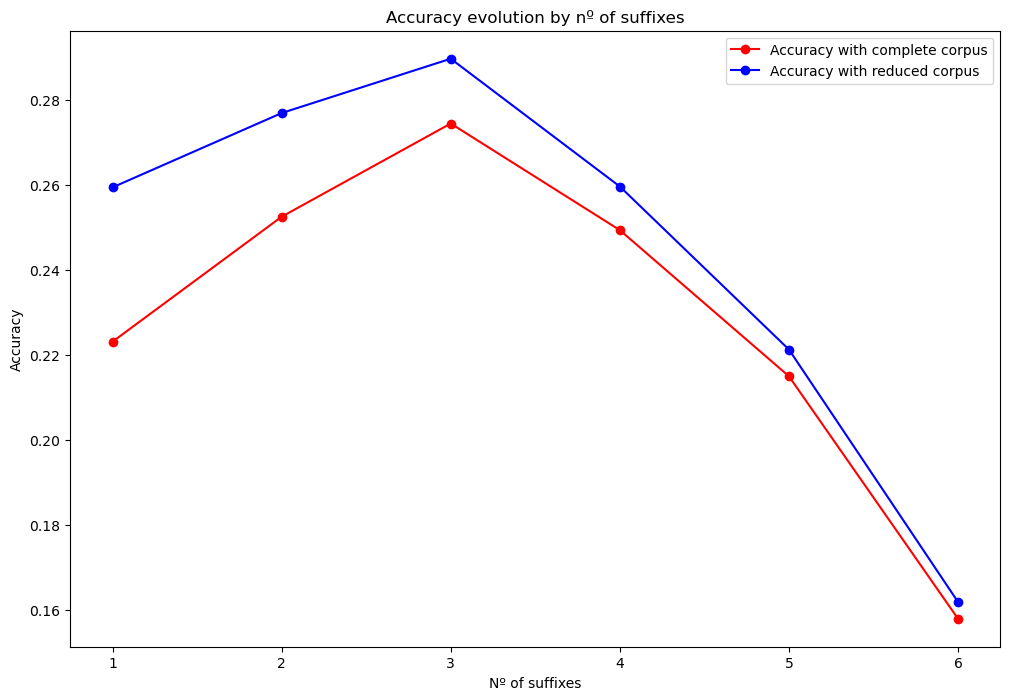

In [28]:
x = [i for i in range(1,7)]
plt.figure(figsize=(12, 8)) 
plt.plot(x, [statistics.mean(acc) for acc in acc_completed], 'ro-', label='Accuracy with complete corpus')
plt.plot(x, [statistics.mean(acc) for acc in acc_reduced], 'bo-', label='Accuracy with reduced corpus')
plt.title('Accuracy evolution by nº of suffixes')
plt.xlabel('Nº of suffixes')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
def KFold_tnt(data, folds, s=True): ## CON AFFIX TAGGER
    newsentences=np.asarray(data) 
    kf=KFold(n_splits=folds, shuffle=s) # shuffle default=False
    scores=[] 
    longitudes=[]

    for train_index, test_index in kf.split(newsentences):   
        x_train = newsentences[train_index]
        x_test=newsentences[test_index]
        longitudes.append(len(x_test))

        tagger_suffix = AffixTagger(train=[i for i in x_train], affix_length = -3)
        tagger_tnt = tnt.TnT(N=100, unk = tagger_suffix, Trained = True)
        tagger = tagger_tnt.train(x_train)
        accuracy = tagger_tnt.evaluate(x_test)
        scores.append(accuracy)
    
    return scores,longitudes

In [30]:
s_reduced,l_reduced=KFold_tnt(reduced_corpus, 10)

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\3323187295.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)
C:\Users\annal\AppData\Local\Temp\ipykernel_12720\3323187295.py:15: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = tagger_tnt.evaluate(x_test)


In [31]:
s_completed,l_completed=KFold_tnt(completed_corpus, 10)

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\3323187295.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)
C:\Users\annal\AppData\Local\Temp\ipykernel_12720\3323187295.py:15: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = tagger_tnt.evaluate(x_test)


In [32]:
def tnt_chart(folds,s, text='for original data'):
    x=[i for i in range(folds)] 
    y,longitudes=s
    ic95=[ic(longitudes[i],y[i]) for i in range(0,len(longitudes))]
    plt.axis([-1,10, 0.85, 1])#([-1,10, min(scores)-0.1, max(scores)+0.1]) 
    plt.ylabel('Accuracy') 
    plt.xlabel('Fold') 
    plt.title(f'{folds}-fold cross validation {text}')
    plt.errorbar(x,y,yerr=ic95,linestyle='None')
    plt.plot(x,y,'ro') 
    plt.show()

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\3323187295.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)
C:\Users\annal\AppData\Local\Temp\ipykernel_12720\3323187295.py:15: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = tagger_tnt.evaluate(x_test)


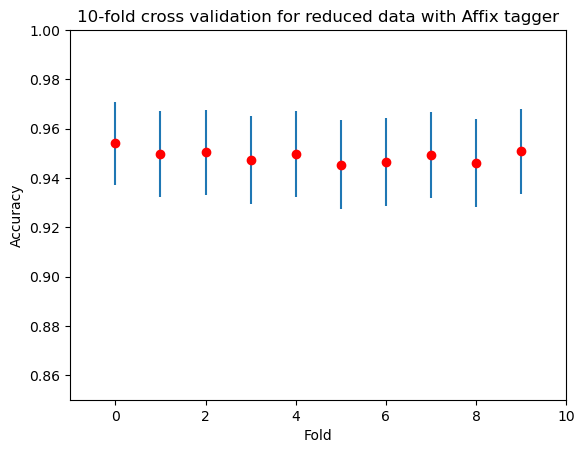

In [33]:
tnt_chart(10,KFold_tnt(reduced_corpus, 10, s=True), text='for reduced data with Affix tagger')

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\3323187295.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)
C:\Users\annal\AppData\Local\Temp\ipykernel_12720\3323187295.py:15: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = tagger_tnt.evaluate(x_test)


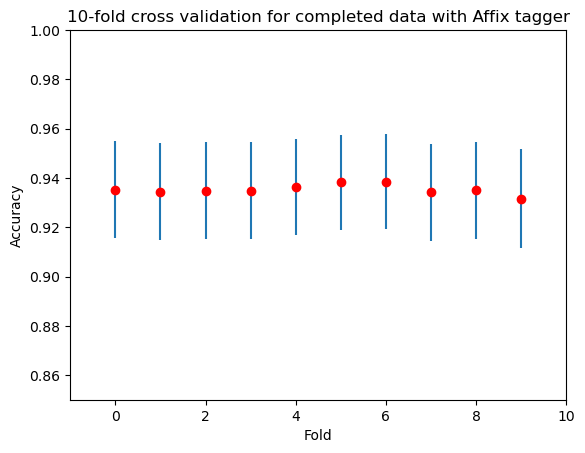

In [34]:
tnt_chart(10,KFold_tnt(completed_corpus, 10, s=True), text='for completed data with Affix tagger')

In [35]:
def KFold_tnt_no_suavizado(data, folds, s=True): ## SIN AFFIX TAGGER
    newsentences=np.asarray(data) 
    kf=KFold(n_splits=folds, shuffle=s) # shuffle default=False
    scores=[] 
    longitudes=[]

    for train_index, test_index in kf.split(newsentences):   
        x_train = newsentences[train_index]
        x_test=newsentences[test_index]
        longitudes.append(len(x_test))

        tagger_tnt = tnt.TnT()
        tagger = tagger_tnt.train(x_train)
        accuracy = tagger_tnt.evaluate(x_test)
        scores.append(accuracy)
    
    return scores,longitudes

In [36]:
sn_tnt_reduced,ln_tnt_reduced=KFold_tnt_no_suavizado(reduced_corpus, 10, s=True)
sn_tnt_completed,ln_tnt_completed=KFold_tnt_no_suavizado(completed_corpus, 10, s=True)

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1960938458.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)
C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1960938458.py:14: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = tagger_tnt.evaluate(x_test)


C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1960938458.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)
C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1960938458.py:14: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = tagger_tnt.evaluate(x_test)


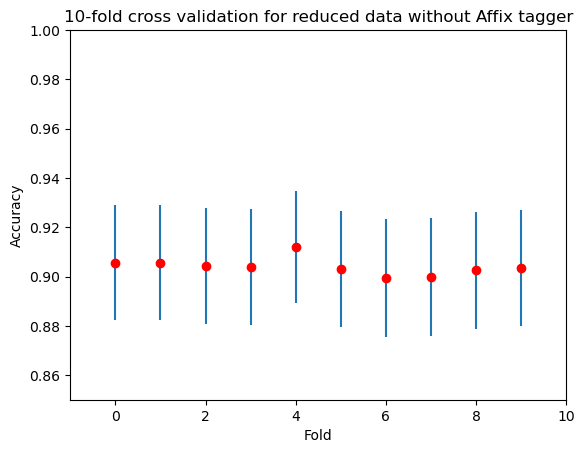

In [37]:
tnt_chart(10,KFold_tnt_no_suavizado(reduced_corpus, 10, s=True), text='for reduced data without Affix tagger')

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1960938458.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)
C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1960938458.py:14: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = tagger_tnt.evaluate(x_test)


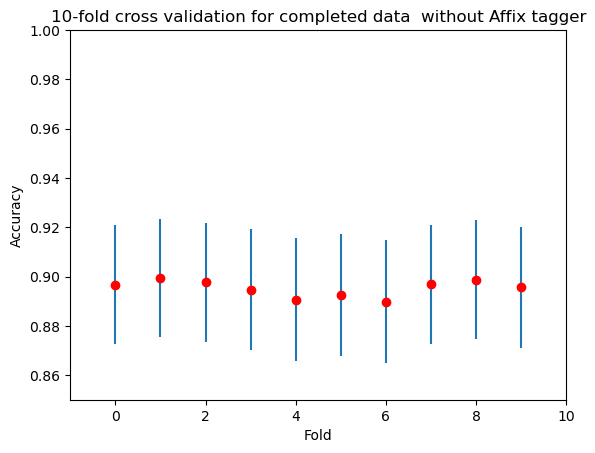

In [38]:
tnt_chart(10,KFold_tnt_no_suavizado(completed_corpus, 10, s=True), text='for completed data  without Affix tagger')

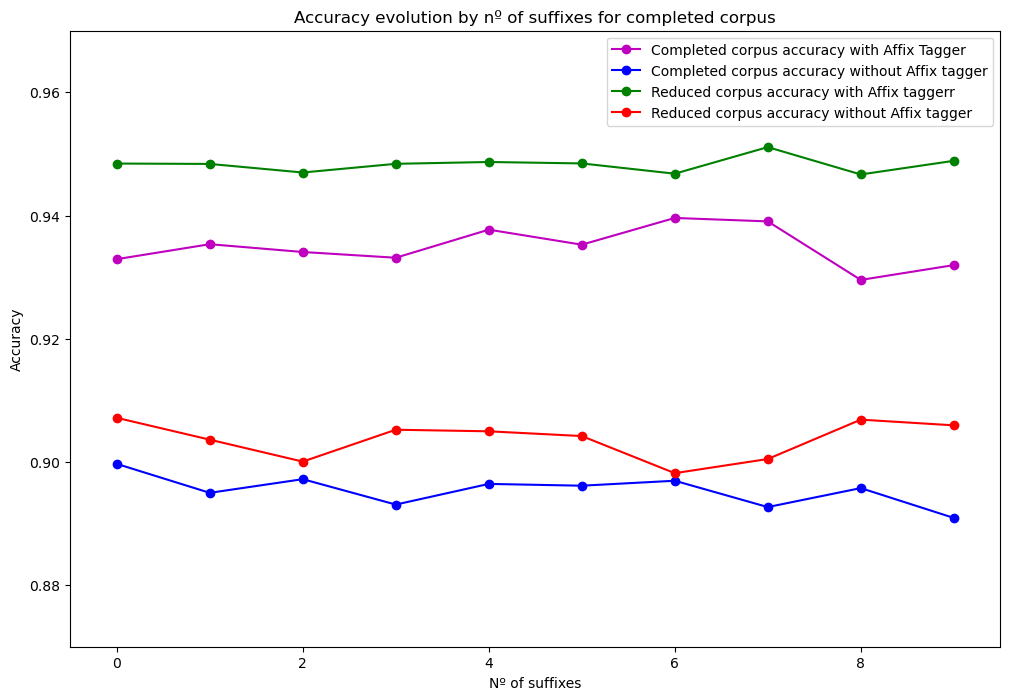

In [39]:
x = [i for i in range(0,10)]
plt.figure(figsize=(12, 8)) 
plt.plot(x, s_completed, 'mo-', label='Completed corpus accuracy with Affix Tagger')
plt.plot(x, sn_tnt_completed, 'bo-', label='Completed corpus accuracy without Affix tagger')

plt.plot(x, s_reduced, 'go-', label='Reduced corpus accuracy with Affix taggerr')
plt.plot(x, sn_tnt_reduced, 'ro-', label='Reduced corpus accuracy without Affix tagger')
plt.title('Accuracy evolution by nº of suffixes for completed corpus')
plt.xlabel('Nº of suffixes')
plt.ylabel('Accuracy')
plt.axis([-0.5, 9.5, 0.87, 0.97]) 

plt.legend()
plt.show()

### Tarea 4: Evaluación del resto de etiquetadores.

Se deberán utilizar otros paradigmas de etiquetado. Como mínimo el etiquetador de Brill y algún otro
como, CRF, perceptron. Se deberá realizar una comparativa de prestaciones respecto a los
etiquetadores tnt y hmm, utilizando el juego de categorías reducido.
Cuando se utilice el etiquetador de Brill, probar con diferentes etiquetados iniciales, por ejemplo
probar con Unigram Tagger y con hmm tagger.
La comparación puede ser sólo de una partición, si el coste temporal de la validación cruzada
requiere mucho tiempo.

In [41]:
train,test= train_test_split(reduced_corpus,test_size=0.1, random_state=1234, shuffle=s)

#### HMM 

In [42]:
# importar función auxiliar creada para HMM 

hmm_acc=hmm_model(train,test)

In [43]:
s_hmm, l_hmm=KFold_hmm(reduced_corpus, 5)


C:\Users\annal\AppData\Local\Temp\ipykernel_12720\540525373.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


In [44]:
s_hmm

[0.9260604488260474,
 0.9232420965488695,
 0.9265253024586965,
 0.9243134457634891,
 0.926371765701889]

#### TNT 

In [45]:
# importar función auxiliar creada para TNT 

tnt_acc=tnt_model(train,test)

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\423551754.py:4: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  acc = tagger_tnt.evaluate(test)


##### Con Affix Tagger

In [46]:
s_tnt_Affix,l_tnt_Affix=KFold_tnt(reduced_corpus, 5, s=True)

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\3323187295.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)
C:\Users\annal\AppData\Local\Temp\ipykernel_12720\3323187295.py:15: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = tagger_tnt.evaluate(x_test)


In [47]:
##### Sin Affix Tagger

In [48]:
s_tnt,l_tnt=KFold_tnt_no_suavizado(reduced_corpus, 5, s=True)

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1960938458.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)
C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1960938458.py:14: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy = tagger_tnt.evaluate(x_test)


#### Greedy Averaged Perceptron tagger

In [49]:
pt = PerceptronTagger(load=False)
pt.train(train)
perceptron_acc=pt.evaluate(test)

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\2490924626.py:3: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  perceptron_acc=pt.evaluate(test)


In [50]:
def KFold_perceptron(data, folds, s=True):
    newsentences=np.asarray(data) 
    kf=KFold(n_splits=folds, shuffle=s) # shuffle default=False
    scores=[] 
    longitudes=[]

    for train_index, test_index in kf.split(newsentences):   
        x_train = newsentences[train_index]
        x_test=newsentences[test_index]
        longitudes.append(len(x_test))

        pt = PerceptronTagger(load=False)
        pt.train(x_train)
        accuracy=pt.evaluate(x_test)
        
        scores.append(accuracy)
    
    return scores,longitudes

In [51]:
s_percp,l_percep=KFold_perceptron(reduced_corpus, 5, s=True)

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1681035729.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)
C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1681035729.py:14: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  accuracy=pt.evaluate(x_test)


In [52]:
s_percp

[0.9665034177513553,
 0.9683431197344907,
 0.9665291629679912,
 0.9680394791236048,
 0.9658726224332715]

#### Brill tagger con etiquetadir inicial Unigram

In [53]:
unigram_tagger = UnigramTagger(train)
brill.Template._cleartemplates()
templates = brill.nltkdemo18plus()
trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger = unigram_tagger
                                                    , templates = templates
                                                    , trace = 3
                                                    , deterministic = True)
brill_tagger = trainer.train(train, max_rules = 500)
brill_acc=brill_tagger.evaluate(test)

TBL train (fast) (seqs: 5427; tokens: 173862; tpls: 23; min score: 2; min acc: None)
Finding initial useful rules...
    Found 67245 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
10761212 136   0  | pr->cs if Pos:vmi@[-3,-2,-1]
 235 247  12   0  | da->pp if Pos:vmi@[1]
 180 345 165  11  | nc->aq if Pos:nc@[-1]
 141 296 155   2  | pr->cs if Pos:sp@[-1]
 100 110  10   0  | aq->vmp if Pos:vai@[-1]
  97 122  25   0  | pr->cs if Pos:vai@[-3,-2,-1]
  91 109  18  11  | di->pi if Pos:sp@[1]
  82 131  49   1  | pr->cs if Pos:rg@[-2,-1]
  78  79   1   0  | pr->cs if Pos:vmn@[-1]
  60  64   4   0  | pr->cs if Pos:vsi@[-1]
  54  61   7   8  | di

   3   3   0   0  | aq->nc if Pos:di@[-1] & Pos:vmi@[1]
   3   4   1   0  | aq->nc if Pos:dn@[-1] & Pos:sp@[1]
   3   3   0   0  | aq->nc if Pos:sp@[-1] & Pos:vmn@[1]
   3   3   0   0  | cs->pr if Pos:nc@[-1] & Pos:vms@[1]
   3   3   0   0  | cs->pr if Pos:vai@[-1] & Pos:vmi@[1]
   3   5   2   0  | di->pi if Pos:sp@[-1] & Pos:rg@[1]
   3   3   0   0  | nc->vmi if Pos:pr@[-1] & Pos:da@[1]
   3   4   1   0  | nc->vmp if Pos:vai@[-1] & Pos:rg@[1]
   3   3   0   1  | pi->rg if Pos:nc@[-1] & Pos:aq@[1]
   3   3   0   0  | pr->cs if Pos:cc@[-1] & Pos:dp@[1]
   3   4   1   0  | pr->cs if Pos:cc@[-1] & Pos:sp@[1]
   3   4   1   0  | rg->nc if Pos:da@[-1] & Pos:Fc@[1]
   3   5   2   0  | rg->nc if Pos:da@[-1] & Pos:sp@[1]
   3   7   4   0  | aq->nc if Word:veces@[-1]
   3   3   0   0  | aq->rg if Word:da@[-1]
   3   3   0   0  | cs->pr if Word:allí@[-1]
   3   3   0   0  | dd->np if Word:al@[-1]
   3   3   0   0  | pr->cs if Word:cierto@[-1]
   3   3   0   0  | di->pi if Word:nos@[1]
   3   3  

   2   2   0   0  | pr->cs if Word:ahí@[1,2]
   2   2   0   0  | cs->pr if Word:Fue@[-3,-2,-1]
   2   2   0   0  | cs->pr if Word:edificio@[-3,-2,-1]
   2   2   0   0  | cs->pr if Word:próximo@[-3,-2,-1]
   2   2   0   0  | nc->aq if Word:embargo@[-3,-2,-1]
   2   2   0   0  | pn->rg if Word:dice@[-3,-2,-1]
   2   2   0   0  | pr->cs if Word:medios@[-3,-2,-1]
   2   2   0   0  | pr->cs if Word:tanta@[-3,-2,-1]
   2   2   0   0  | vsi->vmi if Word:contrataciones@[-3,-2,-1]
   2   2   0   0  | cc->cs if Word:atacará@[1,2,3]
   2   2   0   0  | cc->rg if Word:aumentar@[1,2,3]
   2   2   0   0  | cs->pr if Word:coche@[1,2,3]
   2   2   0   0  | cs->pr if Word:tardado@[1,2,3]
   2   2   0   0  | pn->nc if Word:para@[1,2,3]
   2   3   1   0  | pr->cs if Word:mes@[1,2,3]
   2   2   0   0  | Z->W if Word:del@[-1] & Word:,@[1]
   2   2   0   0  | aq->nc if Word:El@[-1] & Word:que@[1]
   2   2   0   0  | aq->nc if Word:En@[-1] & Word:,@[1]
   2   2   0   0  | aq->nc if Word:en@[-1] & Word:en@[1]

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\255093161.py:9: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  brill_acc=brill_tagger.evaluate(test)


In [54]:
def KFold_bt(data, folds, s=True):
    newsentences=np.asarray(data) 
    kf=KFold(n_splits=folds, shuffle=s) # shuffle default=False
    scores=[] 
    longitudes=[]

    for train_index, test_index in kf.split(newsentences):   
        train = newsentences[train_index]
        test=newsentences[test_index]
        unigram_tagger = UnigramTagger(t for t in train)
        brill.Template._cleartemplates()
        templates = brill.nltkdemo18plus()
        trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger = unigram_tagger
                                                            , templates = templates
                                                            , trace = 3
                                                            , deterministic = True)
        brill_tagger = trainer.train(train, max_rules = 500)
        brill_acc=brill_tagger.evaluate(test)
        scores.append(brill_acc)
    
    return scores,longitudes

In [55]:
s_bt,l_bt=KFold_bt(reduced_corpus, 5, s=True)

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\441561624.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


TBL train (fast) (seqs: 4824; tokens: 154234; tpls: 23; min score: 2; min acc: None)
Finding initial useful rules...
    Found 61612 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
 9371071 134   0  | pr->cs if Pos:vmi@[-3,-2,-1]
 205 214   9   0  | da->pp if Pos:vmi@[1]
 131 282 151  13  | nc->aq if Pos:nc@[-1]
 126 167  41   0  | pr->cs if Pos:rg@[-2,-1]
  90 106  16   0  | pr->cs if Word:de@[-1]
  77  90  13   9  | di->pi if Pos:sp@[1]
  76 100  24   0  | pr->cs if Pos:vai@[-3,-2,-1]
  63  70   7   1  | aq->vmp if Pos:vai@[-1]
  63  64   1   0  | pr->cs if Pos:vmn@[-1]
  61  66   5   0  | vmp->aq if Pos:nc@[-1]
  49  49   0   8  | d

   3   3   0   0  | p0->pp if Word:sí@[1,2,3]
   3   3   0   0  | aq->nc if Word:de@[-1] & Word:"@[1]
   3   4   1   0  | aq->nc if Word:los@[-1] & Word:.@[1]
   3   3   0   0  | rg->pi if Word:un@[-1] & Word:de@[1]
   3   3   0   0  | di->pi if Word:y@[-1] & Pos:rg@[1]
   3   3   0   0  | dn->nc if Word:la@[-1] & Pos:aq@[1]
   3   7   4   0  | aq->nc if Pos:da@[-1] & Word:del@[1]
   5   5   0   0  | nc->aq if Pos:da@[-1] & Word:mayor@[0] & Pos:sp@[1]
   3   3   0   0  | cs->pr if Pos:nc@[-1] & Word:este@[1]
   3   3   0   0  | aq->nc if Word:al@[-1] & Word:estadounidense@[0] &
                  |   Pos:np@[1]
   3   3   0   0  | cs->pr if Word:y@[-1] & Word:que@[0] & Pos:vmi@[1]
   3   4   1   0  | pr->cs if Word:a@[-1] & Word:que@[0] & Pos:sn@[1]
   3   3   0   0  | rg->di if Word:con@[-1] & Word:tanto@[0] & Pos:nc@[1]
   3   3   0   0  | ao->nc if Pos:da@[-1] & Word:cuarto@[0] & Word:de@[1]
   3   4   1   0  | cs->pr if Pos:aq@[-1] & Word:que@[0] & Word:no@[1]
   3   3   0   0  | pr

   2   2   0   0  | rg->vss if Pos:vmp@[1]
   2   2   0   0  | aq->vmp if Word:vez@[-1] & Pos:da@[1]
   2   2   0   0  | ao->nc if Pos:sp@[-1] & Word:de@[1]
   2   2   0   0  | aq->nc if Pos:sp@[-1] & Word:para@[1]
   2   2   0   0  | aq->vmp if Pos:vsi@[-1] & Word:desde@[1]
   2   2   0   0  | cs->pr if Pos:aq@[-1] & Word:son@[1]
   2   2   0   0  | nc->rg if Pos:vmi@[-1] & Word:la@[1]
   2   2   0   0  | nc->vmp if Pos:vsi@[-1] & Word:por@[1]
   2   2   0   0  | pi->nc if Pos:da@[-1] & Word:de@[1]
   2   2   0   0  | aq->nc if Word:,@[-1] & Word:general@[0] & Pos:np@[1]
   2   2   0   0  | aq->nc if Word:-@[-1] & Word:plena@[0] & Pos:Fg@[1]
   2   2   0   0  | aq->nc if Word:al@[-1] & Word:hecho@[0] & Pos:sp@[1]
   2   2   0   0  | aq->nc if Word:candidato@[-1] & Word:opositor@[0] &
                  |   Pos:Fc@[1]
   2   2   0   0  | aq->nc if Word:el@[-1] & Word:colombiano@[0] & Pos:np@[1]
   2   3   1   0  | aq->nc if Word:la@[-1] & Word:alemana@[0] & Pos:np@[1]
   2   2   0   0  

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\441561624.py:18: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  brill_acc=brill_tagger.evaluate(test)


TBL train (fast) (seqs: 4824; tokens: 153364; tpls: 23; min score: 2; min acc: None)
Finding initial useful rules...
    Found 61566 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
 9731092 119   1  | pr->cs if Pos:vmi@[-3,-2,-1]
 205 213   8   0  | da->pp if Pos:vmi@[1]
 138 267 129   3  | pr->cs if Pos:sp@[-1]
 132 269 137  12  | nc->aq if Pos:nc@[-1]
  84  90   6   1  | aq->vmp if Pos:vai@[-1]
  84 102  18   6  | di->pi if Pos:sp@[1]
  82 103  21   0  | pr->cs if Pos:vai@[-3,-2,-1]
  74 113  39   1  | pr->cs if Pos:rg@[-2,-1]
  67  69   2   0  | pr->cs if Pos:vmn@[-1]
  53  58   5   0  | pr->cs if Pos:vsi@[-1]
  48  53   5   0  | vm

   3   3   0   1  | pi->di if Pos:nc@[-1] & Pos:Fp@[1]
   3   4   1   0  | pr->cs if Pos:Fe@[-1] & Pos:da@[1]
   3   3   0   0  | aq->nc if Word:transmisión@[-1]
   3   3   0   0  | aq->rg if Word:da@[-1]
   3   3   0   0  | cs->pr if Word:Ahora@[-1]
   3   3   0   0  | dd->np if Word:al@[-1]
   3   3   0   0  | vmi->nc if Word:La@[-1]
   3   3   0   0  | pp->da if Pos:nc@[1]
   3   3   0   0  | vsi->nc if Word:la@[-1]
   3   3   0   0  | di->pi if Word:nos@[1]
   3   3   0   0  | di->pi if Word:que@[1]
   3   3   0   3  | dn->pn if Word:y@[1]
   3   3   0   0  | cs->pr if Word:día@[-2]
   3   3   0   0  | rn->rg if Word:otra_cosa_que@[2]
   3   3   0   0  | pr->cs if Word:mejor@[-3,-2,-1]
   3   3   0   0  | aq->nc if Word:El@[-1] & Word:,@[1]
   3   4   1   0  | aq->nc if Word:al@[-1] & Word:.@[1]
   3   5   2   0  | aq->nc if Word:del@[-1] & Word:,@[1]
   3   5   2   0  | aq->nc if Word:la@[-1] & Word:de@[1]
   3   5   2   0  | aq->nc if Word:los@[-1] & Word:de@[1]
   3   3   0   0 

   2   3   1   0  | aq->nc if Word:de@[-1] & Word:que@[1]
   2   5   3   0  | aq->nc if Word:del@[-1] & Word:.@[1]
   2   3   1   0  | aq->nc if Word:en@[-1] & Word:,@[1]
   2   2   0   0  | aq->nc if Word:en@[-1] & Word:en@[1]
   2   2   0   0  | aq->nc if Word:en@[-1] & Word:y@[1]
   2   2   0   0  | aq->nc if Word:los@[-1] & Word:a@[1]
   2   2   0   0  | aq->nc if Word:un@[-1] & Word:con@[1]
   2   2   0   0  | da->pp if Word:que@[-1] & Word:diferencia@[1]
   2   2   0   0  | nc->vmi if Pos:pp@[-1] & Pos:vsi@[1]
   2   2   0   0  | di->pi if Word:pero@[-1] & Word:lo@[1]
   2   2   0   0  | pr->cs if Word:y@[-1] & Word:probablemente@[1]
   2   2   0   0  | aq->nc if Word:La@[-1] & Pos:aq@[1]
   2   2   0   0  | aq->nc if Word:con@[-1] & Pos:sp@[1]
   2   2   0   0  | aq->nc if Word:el@[-1] & Pos:vsi@[1]
   2   3   1   0  | aq->nc if Word:también@[-1] & Pos:np@[1]
   2   2   0   0  | cs->pr if Word:poco@[-1] & Pos:vmn@[1]
   2   2   0   0  | aq->vmp if Pos:vsi@[-1] & Word:desde@[1]
 

   6   9   3   0  | p0->pp if Word:lo@[1]
   6   7   1   0  | aq->nc if Word:el@[-1] & Word:.@[1]
   6   6   0   0  | aq->nc if Word:los@[-1] & Word:y@[1]
   6   6   0   0  | nc->aq if Word:lo@[-1] & Word:de@[1]
   6  14   8   0  | pr->cs if Word:,@[-1] & Word:que@[0] & Pos:sn@[1]
   6   6   0   0  | aq->nc if Pos:da@[-1] & Word:general@[0] & Pos:np@[1]
   6   6   0   0  | cs->pr if Pos:nc@[-1] & Word:que@[0] & Pos:pp@[1]
   5   5   0   0  | pr->cs if Pos:cs@[-1]
   5   5   0   0  | rg->nc if Pos:dd@[-1]
   5   5   0   0  | vmp->nc if Pos:dd@[-1]
   5   5   0   0  | vsn->nc if Pos:di@[-1]
   5   5   0   0  | di->pi if Pos:vms@[1]
   5   7   2   0  | di->pi if Pos:vsi@[1]
   5   6   1   0  | di->pi if Pos:cc@[-1] & Pos:rg@[1]
   5   5   0   0  | pr->cs if Word:prensa@[-1]
   5   5   0   0  | pr->cs if Word:sus@[1]
   5   5   0   0  | p0->pp if Word:sí@[1,2,3]
   5   5   0   0  | aq->nc if Word:al@[-1] & Word:.@[1]
   5   5   0   0  | aq->nc if Word:países@[-1] & Word:de@[1]
   5   7   2

   2   2   0   0  | vai->vam if Pos:sn@[-1] & Pos:rg@[1]
   2   2   0   0  | vmi->nc if Pos:sp@[-1] & Pos:rn@[1]
   2   2   0   0  | vsi->nc if Pos:pp@[-1] & Pos:np@[1]
   2   2   0   0  | vsi->vmi if Pos:np@[-1] & Pos:vmg@[1]
   2   2   0   0  | aq->nc if Word:ligandos@[-1]
   2   2   0   0  | aq->nc if Word:página@[-1]
   2   2   0   0  | aq->rg if Word:da@[-1]
   2   2   0   0  | cs->pr if Word:allí@[-1]
   2   2   0   0  | dn->nc if Word:años@[-1]
   2   2   0   0  | dn->nc if Word:un@[-1]
   2   2   0   0  | nc->aq if Word:bien@[-1]
   2   2   0   0  | nc->aq if Word:mostró@[-1]
   2   2   0   0  | nc->aq if Word:tan@[-1]
   2   2   0   0  | nc->vmi if Word:Brasil@[-1]
   2   2   0   1  | nc->vmi if Word:nos@[-1]
   2   2   0   0  | nc->vmi if Word:quien@[-1]
   2   2   0   0  | nc->vmp if Word:hubiera@[-1]
   2   2   0   0  | nc->vmp if Word:hubiese@[-1]
   2   2   0   1  | nc->vms if Word:me@[-1]
   2   2   0   0  | p0->pp if Word:extremos@[-1]
   2   2   0   0  | pr->cs if Word

 227 235   8   0  | da->pp if Pos:vmi@[1]
 137 267 130   2  | pr->cs if Pos:sp@[-1]
 126 280 154  11  | nc->aq if Pos:nc@[-1]
  94 116  22   0  | pr->cs if Pos:vai@[-3,-2,-1]
  77  92  15  10  | di->pi if Pos:sp@[1]
  70 115  45   1  | pr->cs if Pos:rg@[-2,-1]
  69  78   9   0  | aq->vmp if Pos:vai@[-1]
  62  63   1   0  | pr->cs if Pos:vmn@[-1]
  54  59   5   0  | vmp->aq if Pos:nc@[-1]
  49  49   0   7  | dn->pn if Pos:sp@[1]
  42  48   6   0  | pr->cs if Pos:vsi@[-1]
  42  49   7   8  | di->pi if Pos:Fc@[1]
  32  32   0   0  | cs->pr if Pos:da@[-1]
  28  28   0   0  | da->pp if Pos:vai@[1]
  28  28   0   0  | cs->pr if Word:al@[-1]
  25  25   0   0  | nc->vmp if Word:ha@[-1]
  23  25   2   0  | cs->pr if Pos:nc@[-1] & Word:que@[0] & Pos:vmi@[1]
  20  22   2   3  | di->pi if Pos:Fp@[1]
  20  31  11   0  | di->pi if Pos:vmi@[1]
  19  19   0   0  | da->pp if Pos:vms@[1]
  16  16   0   0  | cs->pr if Word:del@[-1]
  16  17   1   0  | sp->cs if Word:,@[-1] & Word:según@[0] & Pos:vmi@[1]


   3   3   0   0  | cs->pr if Word:además@[1,2]
   3   3   0   0  | aq->nc if Word:El@[-1] & Word:,@[1]
   3   4   1   0  | aq->nc if Word:al@[-1] & Word:.@[1]
   3   5   2   0  | aq->nc if Word:el@[-1] & Word:.@[1]
   3   3   0   0  | rg->pi if Word:un@[-1] & Word:de@[1]
   3  10   7   0  | aq->nc if Word:al@[-1] & Pos:np@[1]
   3   3   0   0  | aq->vmp if Pos:vss@[-1] & Word:por@[1]
   3   3   0   0  | cs->pr if Word:en@[-1] & Word:donde@[0] & Pos:da@[1]
   3   3   0   0  | cs->pr if Word:y@[-1] & Word:que@[0] & Pos:vmi@[1]
   3   3   0   0  | pr->cs if Word:,@[-1] & Word:que@[0] & Pos:np@[1]
   3   4   1   0  | pr->cs if Word:y@[-1] & Word:que@[0] & Pos:np@[1]
   3   3   0   0  | rg->di if Word:,@[-1] & Word:mucho@[0] & Pos:nc@[1]
   3   3   0   0  | rg->di if Word:con@[-1] & Word:tanto@[0] & Pos:nc@[1]
   3   4   1   0  | cs->pr if Pos:sp@[-1] & Word:donde@[0] & Word:*0*@[1]
   3   3   0   0  | nc->rg if Pos:da@[-1] & Word:más@[0] & Word:de@[1]
   3   4   1   0  | pr->cs if Pos:cc@

   2   2   0   0  | nc->vmi if Word:que@[-1] & Word:para@[1]
   2   2   0   0  | sp->aq if Word:muy@[-1] & Word:grado@[1]
   2   2   0   0  | vmp->aq if Word:bien@[-1] & Word:,@[1]
   2   2   0   0  | aq->nc if Word:dos@[-1] & Pos:sp@[1]
   2   3   1   0  | aq->nc if Word:el@[-1] & Pos:vsi@[1]
   2   2   0   0  | aq->nc if Word:también@[-1] & Pos:np@[1]
   2   2   0   0  | aq->vmp if Word:vez@[-1] & Pos:da@[1]
   2   2   0   0  | cs->pr if Word:en@[-1] & Pos:di@[1]
   2   2   0   0  | cs->pr if Word:en@[-1] & Pos:vmi@[1]
   2   2   0   0  | nc->pd if Word:todos@[-1] & Pos:sp@[1]
   2   2   0   0  | nc->vmp if Word:habría@[-1] & Pos:aq@[1]
   2   2   0   0  | pp->da if Word:a@[-1] & Pos:vmi@[1]
   2   2   0   0  | vmi->nc if Pos:da@[-1]
   2   2   0   0  | aq->nc if Pos:da@[-1] & Word:o@[1]
   2   2   0   0  | aq->nc if Pos:nc@[-1] & Word:uno@[1]
   2   2   0   0  | aq->nc if Pos:sp@[-1] & Word:del@[1]
   2   2   0   0  | pi->di if Pos:nc@[-1] & Word:para@[1]
   2   2   0   0  | pr->cs 

   5   7   2   0  | rg->nc if Pos:dd@[-1]
   5  20  15   0  | vmp->aq if Pos:rg@[-1]
   6   6   0   0  | cs->pr if Pos:aq@[-1] & Word:que@[0] & Pos:vmi@[1]
   5   5   0   0  | di->pi if Pos:Fd@[1]
   5  13   8   3  | di->pi if Pos:cc@[1]
   6   6   0   0  | pi->di if Pos:pp@[-1]
   5   5   0   3  | dn->pn if Pos:Fp@[1]
   5   5   0   0  | dn->pn if Pos:pr@[1]
   5   6   1   0  | pr->cs if Pos:cc@[-1] & Pos:Fe@[1]
   5   7   2   0  | pr->cs if Pos:np@[-1] & Pos:da@[1]
   5   6   1   0  | rg->nc if Pos:da@[-1] & Pos:cc@[1]
   5   5   0   0  | pr->cs if Word:periodistas@[-1]
   5   5   0   0  | pr->cs if Word:posible@[-1]
   5   9   4   0  | rg->di if Word:tiempo@[1]
   5   6   1   0  | pr->cs if Word:si@[1,2]
   5   5   0   0  | p0->pp if Word:sí@[1,2,3]
   5   5   0   0  | aq->nc if Word:países@[-1] & Word:de@[1]
   5  11   6   0  | cs->pr if Word:en@[-1] & Word:*0*@[1]
   5   5   0   0  | cs->pr if Word:,@[-1] & Word:quien@[0] & Pos:vmi@[1]
   5   5   0   0  | cs->pr if Pos:sp@[-1] & W

   2   2   0   0  | pi->di if Pos:da@[-1] & Pos:aq@[1]
   2   2   0   0  | pr->cs if Pos:Fe@[-1] & Pos:Fe@[1]
   2   2   0   0  | pr->cs if Pos:Fe@[-1] & Pos:np@[1]
   2   2   0   0  | rg->nc if Pos:da@[-1] & Pos:Fp@[1]
   2   2   0   0  | rg->nc if Pos:da@[-1] & Pos:cs@[1]
   2   2   0   0  | rg->nc if Pos:di@[-1] & Pos:Fc@[1]
   2   2   0   0  | rg->pi if Pos:di@[-1] & Pos:Fp@[1]
   2   2   0   0  | di->pi if Pos:vmn@[-1] & Pos:rg@[1]
   2   2   0   0  | vmi->nc if Pos:sp@[-1] & Pos:Fp@[1]
   2   2   0   0  | vmp->aq if Pos:Fc@[-1] & Pos:cs@[1]
   2   3   1   0  | vmp->aq if Pos:Fc@[-1] & Pos:rg@[1]
   2   2   0   0  | aq->nc if Word:simple@[-1]
   2   3   1   0  | aq->nc if Word:sistemas@[-1]
   2   5   3   0  | aq->nc if Word:veces@[-1]
   2   4   2   0  | aq->vmp if Word:serán@[-1]
   2   2   0   0  | cs->pr if Word:allí@[-1]
   2   2   0   0  | nc->aq if Word:bien@[-1]
   2   2   0   0  | nc->aq if Word:estará@[-1]
   2   2   0   0  | nc->aq if Word:mostró@[-1]
   2   2   0   0  

#### Brill tagger con etiquetadir inicial HMM

In [56]:
hmm_tagger = hmm.HiddenMarkovModelTagger.train(train)
brill.Template._cleartemplates()
templates = brill.nltkdemo18plus()
trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger = hmm_tagger
                                                    , templates = templates
                                                    , trace = 3
                                                    , deterministic = True)
brill_tagger = trainer.train(train, max_rules = 500)
brill_hmm=brill_tagger.evaluate(test)

TBL train (fast) (seqs: 5427; tokens: 173862; tpls: 23; min score: 2; min acc: None)
Finding initial useful rules...
    Found 82409 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
  44  57  13  33  | Fg->nc if Word:-@[-1] & Word:-@[1]
  30  33   3   0  | sp->cs if Pos:nc@[-1] & Word:como@[0] & Pos:nc@[1]
  24  24   0   0  | cs->pr if Word:al@[-1]
  21  21   0   9  | vmp->nc if Word:hay@[-1]
  21  27   6   0  | cs->pr if Word:,@[-1] & Word:que@[0] & Pos:sp@[1]
  18  18   0  10  | da->aq if Word:del@[-1]
  17  31  14   0  | pr->cs if Word:de@[-1]
  14  19   5   0  | di->pi if Pos:sp@[1]
  13  42  29   0  | cs->pr if Pos:nc@[-1] & Word:q

   2   2   0   0  | di->vmg if Word:están@[-1]
   2   3   1   0  | nc->aq if Word:orgánicos@[-1]
   2   2   0   0  | nc->aq if Word:televisivo@[-1]
   2   2   0   0  | p0->pp if Word:extremos@[-1]
   2   2   0   0  | pp->vmi if Word:la@[-1]
   2   2   0   0  | pr->ao if Word:vicepresidente@[-1]
   2   2   0   0  | pr->cs if Word:claro@[-1]
   2   2   0   0  | pr->cs if Word:comunicado@[-1]
   2   2   0   0  | pr->cs if Word:evidente@[-1]
   2   2   0   0  | pr->np if Word:pívot@[-1]
   2   2   0   0  | sn->nc if Word:cuyas@[-1]
   2   2   0   0  | sn->nc if Word:cuyos@[-1]
   2   2   0   0  | sn->np if Word:mientras_que@[-1]
   2   2   0   0  | vmi->vsi if Word:57.280@[-1]
   2   2   0   2  | vmn->aq if Word:está@[-1]
   2   2   0   0  | vmn->nc if Word:dé@[-1]
   2   2   0   0  | vmn->np if Word:decía@[-1]
   2   2   0   0  | Fp->nc if Word:1@[1]
   2   2   0   0  | ao->W if Word:víctima@[1]
   2   2   0   0  | cs->pr if Word:cumplir@[1]
   2   2   0   1  | da->aq if Word:gusto@[1]
  

   2   2   0   0  | rg->pi if Word:es@[-1] & Word:algo@[0] & Pos:aq@[1]
   2   2   0   0  | rg->pn if Word:y@[-1] & Word:medio@[0] & Pos:rg@[1]
   2   2   0   0  | vmi->nc if Word:no@[-1] & Word:interferencia@[0] &
                  |   Pos:sp@[1]
   2   2   0   0  | vmi->pd if Word:,@[-1] & Word:tales@[0] & Pos:cs@[1]
   2   2   0   0  | vmn->nc if Word:de@[-1] & Word:inscripción@[0] & Pos:di@[1]
   2   2   0   0  | aq->Z if Pos:nc@[-1] & Word:sub'23@[0] & Word:de@[1]
   2   2   0   0  | aq->Z if Pos:nc@[-1] & Word:29@[0] & Word:de@[1]
   2   2   0   0  | aq->di if Pos:nc@[-1] & Word:alguno@[0] & Word:.@[1]
   2   2   0   0  | aq->pd if Pos:nc@[-1] & Word:eso@[0] & Word:de@[1]
   2   2   0   0  | cs->sp if Pos:Fc@[-1] & Word:según@[0] & Word:él@[1]
   2   2   0   0  | nc->W if Pos:da@[-1] & Word:mes@[0] & Word:pasado@[1]
   2   2   0   0  | nc->pn if Pos:sp@[-1] & Word:cuatro@[0] & Word:de@[1]
   2   2   0   0  | rg->aq if Pos:vmi@[-1] & Word:seguro@[0] & Word:que@[1]
   2   2   0   0

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\2146605491.py:9: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  brill_hmm=brill_tagger.evaluate(test)


In [57]:
def KFold_bt_hmm(data, folds, s=True):
    newsentences=np.asarray(data) 
    kf=KFold(n_splits=folds, shuffle=s) # shuffle default=False
    scores=[] 
    longitudes=[]

    for train_index, test_index in kf.split(newsentences):   
        train = newsentences[train_index]
        test=newsentences[test_index]
        hmm_tagger = hmm.HiddenMarkovModelTagger.train(train)
        brill.Template._cleartemplates()
        templates = brill.nltkdemo18plus()
        trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger = hmm_tagger
                                                            , templates = templates
                                                            , trace = 3
                                                            , deterministic = True)
        brill_tagger = trainer.train(train, max_rules = 500)
        brill_hmm=brill_tagger.evaluate(test)
        scores.append(brill_hmm)
    
    return scores,longitudes

In [58]:
s_bt_hmm,l_bt_hmm=KFold_bt_hmm(reduced_corpus, 5, s=True)

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1935379418.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newsentences=np.asarray(data)


TBL train (fast) (seqs: 4824; tokens: 153669; tpls: 23; min score: 2; min acc: None)
Finding initial useful rules...
    Found 76273 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
  41  52  11  37  | Fg->nc if Word:-@[-1] & Word:-@[1]
  28  32   4   0  | sp->cs if Pos:nc@[-1] & Word:como@[0] & Pos:nc@[1]
  20  40  20   0  | cs->pr if Pos:nc@[-1] & Word:que@[0] & Pos:da@[1]
  19  19   0   0  | cs->pr if Word:al@[-1]
  18  18   0   7  | da->aq if Word:del@[-1]
  18  18   0   8  | vmp->nc if Word:hay@[-1]
  16  22   6   0  | cs->pr if Word:,@[-1] & Word:que@[0] & Pos:sp@[1]
  15  16   1  34  | Fp->vmi if Pos:nc@[1,2,3]
  14  16   2   0  

   2   2   0   0  | ao->W if Word:GMT@[1]
   2   2   0   0  | ao->W if Word:víctima@[1]
   2   2   0   0  | ao->nc if Word:n@[1]
   2   2   0   0  | cs->pr if Word:según@[1]
   2   2   0   1  | da->aq if Word:gusto@[1]
   2   2   0   0  | da->aq if Word:incidentes@[1]
   2   2   0   0  | da->nc if Word:puente@[1]
   2   2   0   0  | di->pi if Word:juntos@[1]
   2   2   0   0  | nc->aq if Word:AVE@[1]
   2   2   0   0  | pi->di if Word:ello@[1]
   2   2   0   0  | pp->p0 if Word:encontramos@[1]
   2   2   0   0  | pp->p0 if Word:vas@[1]
   2   2   0   0  | pr->nc if Word:significa@[1]
   2   3   1   0  | rg->sp if Word:entonces@[1]
   2   2   0   0  | sn->nc if Word:después@[1]
   2   2   0   0  | vmn->aq if Word:de_antemano@[1]
   2   2   0   0  | Z->nc if Word:tipo@[-2]
   2   2   0   0  | aq->nc if Word:holandés@[-2]
   2   2   0   0  | aq->nc if Word:total@[-2]
   2   2   0   0  | aq->vmn if Word:cuesta@[-2]
   2   2   0   0  | cc->rg if Word:tocar@[-2]
   2   2   0   0  | cs->pr if

C:\Users\annal\AppData\Local\Temp\ipykernel_12720\1935379418.py:18: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  brill_hmm=brill_tagger.evaluate(test)


TBL train (fast) (seqs: 4824; tokens: 154192; tpls: 23; min score: 2; min acc: None)
Finding initial useful rules...
    Found 76240 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
  37  51  14  36  | Fg->nc if Word:-@[-1] & Word:-@[1]
  25  25   0   0  | cs->pr if Word:al@[-1]
  23  27   4   0  | sp->cs if Pos:nc@[-1] & Word:como@[0] & Pos:nc@[1]
  20  20   0  10  | da->aq if Word:del@[-1]
  20  20   0   7  | vmp->nc if Word:hay@[-1]
  20  25   5   0  | cs->pr if Word:,@[-1] & Word:que@[0] & Pos:sp@[1]
  18  31  13   0  | pr->cs if Word:de@[-1]
  12  14   2  38  | Fp->vmi if Pos:nc@[1,2,3]
  11  11   0   0  | nc->Fg if Word:-@[-1] & W

   2   2   0   0  | ao->W if Word:GMT@[1]
   2   2   0   0  | ao->W if Word:víctima@[1]
   2   2   0   0  | cs->pr if Word:cumplir@[1]
   2   2   0   0  | cs->pr if Word:según@[1]
   2   2   0   0  | da->aq if Word:incidentes@[1]
   2   2   0   0  | da->nc if Word:puente@[1]
   2   2   0   0  | da->pp if Word:quemó@[1]
   2   2   0   0  | di->nc if Word:alguna@[1]
   2   2   0   0  | nc->W if Word:próximo@[1]
   2   2   0   0  | nc->aq if Word:1.115.856@[1]
   2   2   0   0  | nc->aq if Word:27.050@[1]
   3   3   0   0  | vmi->Z if Pos:aq@[-1] & Pos:vsi@[1]
   2   2   0   0  | nc->aq if Word:AVE@[1]
   2   2   0   0  | p0->pp if Word:conocían@[1]
   2   2   0   0  | pi->di if Word:ellos@[1]
   2   2   0   0  | pp->da if Word:más@[1]
   2   2   0   0  | pp->p0 if Word:encontramos@[1]
   2   2   0   0  | pr->cs if Word:no_sólo@[1]
   2   2   0   0  | pr->nc if Word:significa@[1]
   2   3   1   0  | rg->sp if Word:entonces@[1]
   2   2   0   1  | sn->nc if Word:después@[1]
   2   2   0   

   2   2   0   0  | vmi->di if Pos:pp@[-1] & Word:mismas@[0] & Word:a@[1]
   2   2   0   0  | di->pi if Pos:sp@[-1] & Word:otra@[0] & Pos:aq@[1]
   2   2   0   0  | di->pi if Pos:sp@[-1] & Word:todos@[0] & Pos:rg@[1]
   2   2   0   0  | pt->dt if Pos:sp@[-1] & Word:qué@[0] & Pos:vsi@[1]
   2   2   0   0  | vsi->nc if Pos:dt@[-1]
   2   2   0   0  | rg->pi if Pos:vmi@[-1] & Word:nada@[0] & Pos:aq@[1]
   2   2   0   0  | sp->cs if Pos:nc@[-1] & Word:como@[0] & Pos:dp@[1]
   2   2   0   0  | vmi->vsi if Pos:sn@[-1] & Word:fueron@[0] & Pos:sp@[1]
TBL train (fast) (seqs: 4824; tokens: 154596; tpls: 23; min score: 2; min acc: None)
Finding initial useful rules...
    Found 76358 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   

   2   2   0   0  | pr->cs if Word:evidente@[-1]
   2   2   0   0  | pr->cs if Word:hasta@[-1]
   2   2   0   0  | pr->cs if Word:probable@[-1]
   2   2   0   0  | pr->np if Word:hija@[-1]
   2   2   0   0  | pr->np if Word:pívot@[-1]
   2   2   0   0  | sn->nc if Word:cuyos@[-1]
   2   2   0   2  | vmn->aq if Word:está@[-1]
   2   2   0   0  | vmn->np if Word:decía@[-1]
   2   2   0   1  | vmp->nc if Word:Hay@[-1]
   2   2   0   0  | vsn->nc if Word:del@[-1]
   2   2   0   0  | ao->W if Word:GMT@[1]
   2   2   0   0  | ao->W if Word:víctima@[1]
   2   2   0   0  | cs->pr if Word:cumplir@[1]
   2   2   0   0  | cs->pr if Word:según@[1]
   2   2   0   0  | da->aq if Word:gusto@[1]
   2   2   0   0  | da->pp if Word:quemó@[1]
   3   4   1   0  | nc->vmi if Pos:pp@[-1]
   2   2   0   0  | da->vai if Word:quien@[1]
   2   2   0   0  | di->dn if Word:siglo@[1]
   2   2   0   0  | di->nc if Word:alguna@[1]
   2   2   0   0  | di->pi if Word:juntos@[1]
   2   3   1   0  | nc->W if Word:próxim

  22  27   5   0  | cs->pr if Word:,@[-1] & Word:que@[0] & Pos:sp@[1]
  20  20   0   0  | cs->pr if Word:al@[-1]
  19  19   0   8  | vmp->nc if Word:hay@[-1]
  18  22   4  30  | Fp->aq if Pos:Fg@[1]
  14  26  12   0  | pr->cs if Word:de@[-1]
  12  13   1   0  | sp->cs if Pos:aq@[-1] & Word:como@[0] & Pos:nc@[1]
  11  33  22   0  | cs->pr if Pos:nc@[-1] & Word:que@[0] & Pos:da@[1]
  10  11   1   8  | Fp->np if Pos:nc@[-1] & Pos:Z@[1]
  10  13   3   0  | pr->cs if Word:más@[-2]
   8   8   0   1  | Z->nc if Pos:Fpa@[-1] & Pos:Z@[1]
   8   8   0   0  | cs->pr if Word:del@[-1]
   8   8   0   7  | da->aq if Word:al@[-1]
   8   8   0   0  | nc->Fg if Word:-@[-1] & Word:-@[0] & Pos:Fg@[1]
   8   9   1   0  | sp->cs if Pos:nc@[-1] & Word:como@[0] & Pos:np@[1]
   7   9   2  16  | Fp->vmi if Pos:nc@[2]
   7   7   0   0  | sn->nc if Word:cuyo@[-1]
   7  20  13   0  | cs->pr if Pos:aq@[-1] & Word:que@[0] & Word:*0*@[1]
   7   7   0   0  | aq->nc if Pos:da@[-1] & Word:general@[0] & Pos:np@[1]
   6  

   2   2   0   0  | vai->vam if Word:aquí@[1]
   2   2   0   0  | aq->Fz if Word:'@[-2]
   2   2   0   0  | da->Fz if Pos:Fz@[2]
   2   2   0   0  | aq->nc if Word:hindú@[-2]
   2   2   0   0  | aq->nc if Word:holandés@[-2]
   2   2   0   0  | aq->pn if Word:rata@[-2]
   2   2   0   0  | cc->rg if Word:tocar@[-2]
   2   2   0   0  | cs->pr if Word:9_de_enero@[-2]
   2   2   0   0  | cs->sp if Word:enfermedades@[-2]
   2   2   0   0  | np->Zm if Word:millones@[-2]
   2   2   0   0  | np->Zp if Word:reducción@[-2]
   2   2   0   0  | pr->cs if Word:además@[-2]
   2   2   0   0  | pr->cs if Word:esta@[-2]
   2   4   2   0  | pr->cs if Word:otra@[-2]
   2   2   0   0  | pr->cs if Word:pues@[-2]
   2   2   0   0  | pr->cs if Word:sin_embargo@[-2]
   2   2   0   0  | vmn->Z if Word:500@[-2]
   2   2   0   0  | aq->np if Word:6-1@[2]
   2   2   0   0  | aq->rg if Word:exclusivamente@[2]
   2   2   0   0  | cs->pr if Word:líderes@[2]
   2   2   0   0  | cs->pr if Word:trate@[2]
   2   2   0   

  16  16   0   6  | vmp->nc if Word:hay@[-1]
  14  39  25   0  | cs->pr if Pos:nc@[-1] & Word:que@[0] & Pos:da@[1]
  13  13   0   0  | sp->cs if Pos:aq@[-1] & Word:como@[0] & Pos:nc@[1]
  12  13   1  42  | Fp->np if Pos:nc@[1,2,3]
  10  15   5   0  | di->pi if Pos:sp@[1]
   9   9   0   0  | nc->Fg if Word:-@[-1] & Word:-@[0] & Pos:Fg@[1]
   8   8   0   0  | rg->sp if Word:ahora@[1]
   8   9   1   0  | nc->pn if Pos:sp@[-1] & Word:miles@[0] & Word:de@[1]
   7   7   0   3  | np->vmi if Pos:np@[-1] & Pos:Z@[1]
   7   7   0   0  | cs->pr if Word:del@[-1]
   7  11   4   0  | pr->cs if Word:más@[-2]
   7  10   3   0  | sp->cs if Pos:nc@[-1] & Word:como@[0] & Pos:np@[1]
   6   6   0   0  | Zm->np if Pos:Fc@[-2]
   6   6   0   0  | cs->aq if Word:está@[-1]
   6   6   0   9  | da->aq if Word:al@[-1]
   6   6   0   0  | p0->nc if Word:cuya@[-1]
   6   6   0   0  | p0->nc if Word:cuyos@[-1]
   6  10   4   0  | pr->cs if Word:para@[-1]
   6   6   0   0  | aq->nc if Pos:da@[-1] & Word:general@[0] &

   2   3   1   1  | Fpt->np if Word:a@[-2]
   2   2   0   0  | Z->nc if Word:tipo@[-2]
   2   2   0   0  | cc->rg if Word:tocar@[-2]
   2   2   0   0  | cs->pr if Word:9_de_enero@[-2]
   2   2   0   0  | cs->pr if Word:Hay@[-2]
   2   2   0   1  | cs->pr if Word:ciudad@[-2]
   2   2   0   0  | cs->pr if Word:ocasiones@[-2]
   2   2   0   0  | cs->sp if Word:enfermedades@[-2]
   2   2   0   0  | np->Z if Word:6-4@[-2]
   2   2   0   0  | np->Zp if Word:reducción@[-2]
   2   2   0   0  | pr->cs if Word:Es_decir@[-2]
   2   2   0   0  | pr->cs if Word:menos@[-2]
   2   2   0   0  | pr->cs if Word:pues@[-2]
   2   2   0   0  | vmn->Z if Word:500@[-2]
   2   2   0   0  | vmp->aq if Word:si@[-2]
   2   2   0   0  | aq->nc if Word:mejor@[2]
   2   2   0   0  | aq->np if Word:6-1@[2]
   2   2   0   0  | aq->rg if Word:exclusivamente@[2]
   2   2   0   0  | cs->pr if Word:encuentran@[2]
   2   4   2   0  | cs->pr if Word:hemos@[2]
   2   2   0   0  | pr->cs if Pos:vms@[-2]
   2   2   0   0  | c

#### Representación de una partición

In [59]:
df = pd.DataFrame({'Modelos':['HMM', 'TnT', 'Perceptrón', 'Brill tagger Unigram', 'Brill tagger HMM'],
                   'Accuracy':[hmm_acc, tnt_acc, perceptron_acc, brill_acc,brill_hmm]
                  })

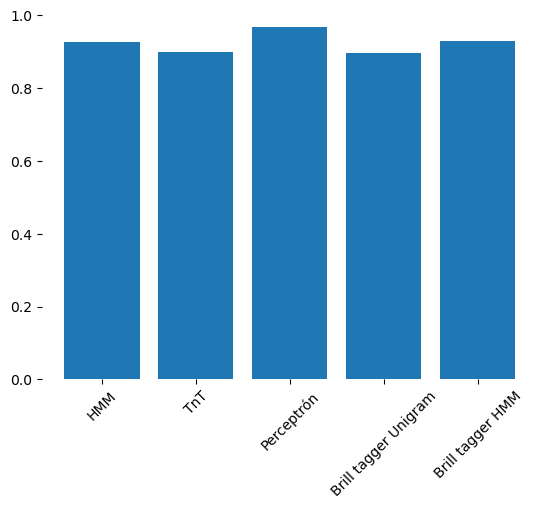

In [60]:
plt.bar(df["Modelos"], df["Accuracy"],
        )
#Eliminar marco del gráfico
plt.xticks(rotation=45)

plt.box(on=None)
#Líneas horizontales en el gráfico
plt.show()

#### Representación 5-Fold

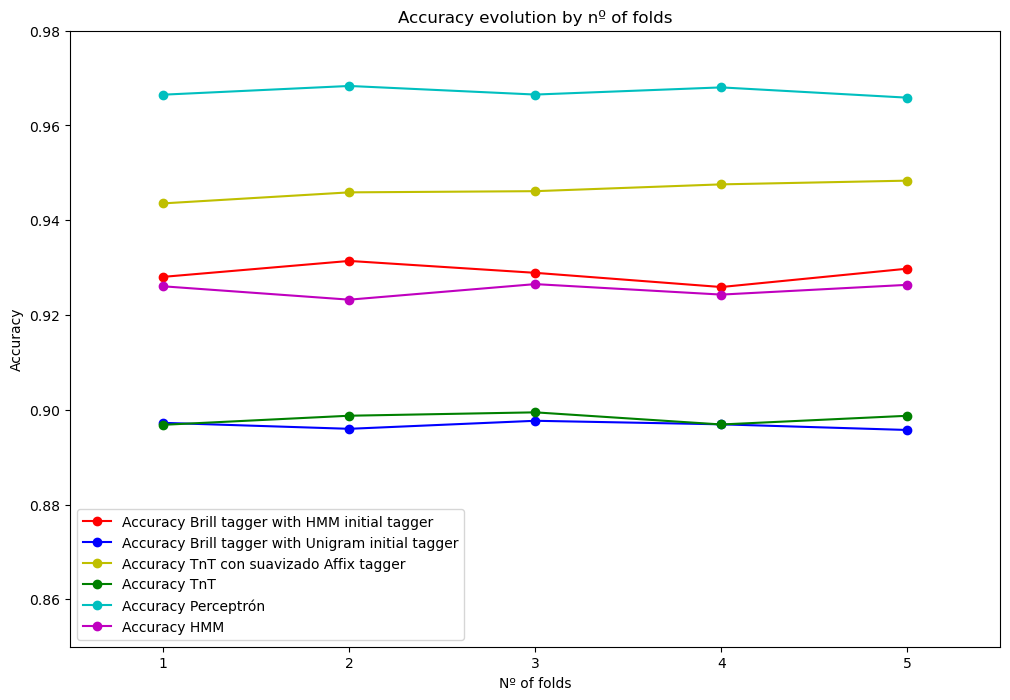

In [61]:
x = [i for i in range(1,6)]
plt.figure(figsize=(12, 8)) 
plt.plot(x,s_bt_hmm, 'ro-', label='Accuracy Brill tagger with HMM initial tagger')
plt.plot(x,s_bt, 'bo-', label='Accuracy Brill tagger with Unigram initial tagger')
plt.plot(x,s_tnt_Affix, 'yo-', label='Accuracy TnT con suavizado Affix tagger')
plt.plot(x,s_tnt, 'go-', label='Accuracy TnT')
plt.plot(x,s_percp, 'co-', label='Accuracy Perceptrón')
plt.plot(x,s_hmm, 'mo-', label='Accuracy HMM')
plt.axis([0.5, 5.5, 0.85, 0.98]) 

plt.title('Accuracy evolution by nº of folds')
plt.xlabel('Nº of folds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Tarea 5.1: Evaluación de la herramienta Spacy.

En dicho estudio se debe contemplar aspectos como: facilidad/problemas de instalación, facilidad de uso,
documentación, funcionalidad, etc. Con cada herramienta estudiada se deberá realizar el etiquetado
morfosintáctico del texto del fichero Alicia.txt. Se debe entregar un fichero tipo texto con el formato:
palabra/etiqueta. Además, se debe explorar la posibilidad de etiquetar el fichero Alicia.txt con
entidades nombradas (NE).


In [62]:
nlp = spacy.load("es_core_news_sm")

In [63]:
input_file = 'C:/Users/annal/OneDrive/Escriptori/LC/Trabajo Académico/Alicia_utf8.txt'

lines = []
with open(input_file, 'r', encoding='utf-8') as file:
    for line in file:
        partes = line.strip().split()
        lines += partes

texto = ' '.join(lines)

In [64]:
texto

'A través de la tarde color de oro el agua nos lleva sin esfuerzo por nuestra parte, pues los que empujan los remos son unos brazos infantiles que intentan, con sus manitas guiar el curso de nuestra barca. Pero, ¡las tres son muy crueles! ya que sin fijarse en el apacible tiempo ni en el ensueño de la hora presente, ¡exigen una historia de una voz que apenas tiene aliento, tanto que ni a una pluma podría soplar! Mas, ¿qué podría una voz tan débil contra la voluntad de las tres? La primera, imperiosamente, dicta su decreto: "¡Comience el cuento!" La segunda, un poco más amable, pide que el cuento no sea tonto, mientras que la tercera interrumpe la historia nada más que una vez por minuto. Conseguido al fin el silencio, con la imaginación las lleva, siguiendo a esa niña soñada, por un mundo nuevo, de hermosas maravillas en el que hasta los pájaros y las bestias hablan con voz humana, y ellas casi se creen estar allí. Y cada vez que el narrador intentaba, seca ya la fuente de su inspiraci

In [65]:
def preprocess_text(text):
    patron = r'[(+*)-.,:;¿?<>!¡\'"]'
    text2= re.sub(patron, ' ', text)# eliminar carácteres especiales para que no los tenga en cuenta como tokens 
    tokens = word_tokenize(text2)  # tokenizar el texto
    #stop_words = set(stopwords.words('english'))
    #filtered_tokens = [word for word in tokens if word not in stop_words] # eliminar las stopwords
   
    return ' '.join(tokens)

In [66]:
texto_preprocesado=preprocess_text(texto)

In [67]:
# Procesar el texto con spaCy
texto_preprocesado = nlp(texto_preprocesado)
texto_preprocesado

A través de la tarde color de oro el agua nos lleva sin esfuerzo por nuestra parte pues los que empujan los remos son unos brazos infantiles que intentan con sus manitas guiar el curso de nuestra barca Pero las tres son muy crueles ya que sin fijarse en el apacible tiempo ni en el ensueño de la hora presente exigen una historia de una voz que apenas tiene aliento tanto que ni a una pluma podría soplar Mas qué podría una voz tan débil contra la voluntad de las tres La primera imperiosamente dicta su decreto Comience el cuento La segunda un poco más amable pide que el cuento no sea tonto mientras que la tercera interrumpe la historia nada más que una vez por minuto Conseguido al fin el silencio con la imaginación las lleva siguiendo a esa niña soñada por un mundo nuevo de hermosas maravillas en el que hasta los pájaros y las bestias hablan con voz humana y ellas casi se creen estar allí Y cada vez que el narrador intentaba seca ya la fuente de su inspiración dejar la narración para el dí

In [68]:
for token in texto_preprocesado:
    print(token.text, token.pos_, token.dep_)


A ADP case
través NOUN fixed
de ADP fixed
la DET det
tarde NOUN nmod
color NOUN nsubj
de ADP case
oro NOUN nmod
el DET det
agua NOUN nsubj
nos PRON iobj
lleva VERB ROOT
sin ADP case
esfuerzo NOUN obl
por ADP case
nuestra DET det
parte NOUN obl
pues SCONJ mark
los DET det
que PRON obj
empujan VERB csubj
los DET det
remos NOUN nsubj
son AUX cop
unos DET det
brazos NOUN advcl
infantiles ADJ amod
que PRON nsubj
intentan VERB acl
con ADP case
sus DET det
manitas NOUN obl
guiar VERB amod
el DET det
curso NOUN obj
de ADP case
nuestra DET det
barca NOUN nmod
Pero CCONJ cc
las DET det
tres NUM nsubj
son AUX cop
muy ADV advmod
crueles ADJ conj
ya ADV mark
que SCONJ fixed
sin ADP mark
fijarse VERB advcl
en ADP case
el DET det
apacible ADJ amod
tiempo NOUN obl
ni CCONJ cc
en ADP case
el DET det
ensueño NOUN conj
de ADP case
la DET det
hora NOUN nmod
presente ADJ amod
exigen VERB advcl
una DET det
historia NOUN obj
de ADP case
una DET det
voz NOUN nmod
que PRON nsubj
apenas ADV advmod
tiene VERB ac

In [69]:
# Recorrer las entidades nombradas y mostrarlas
for entidad in texto_preprocesado.ents:
    print(f"Entidad: {entidad.text} - Tipo: {entidad.label_}")

Entidad: Mas - Tipo: MISC
Entidad: La primera imperiosamente dicta su decreto - Tipo: MISC
Entidad: Comience - Tipo: LOC
Entidad: La segunda un poco más amable - Tipo: MISC
Entidad: Conseguido - Tipo: PER
Entidad: El resto para la próxima - Tipo: MISC
Entidad: Ya - Tipo: MISC
Entidad: País de las Maravillas - Tipo: LOC
Entidad: Alicia para ti este cuento - Tipo: MISC
Entidad: Ponlo - Tipo: LOC


In [70]:
# Recorrer las palabras y etiquetas en el documento
text = []
pos = []
for token in texto_preprocesado:
    text.append(token.text)
    pos.append(token.pos_)
    #print(token.text, token.pos_, token.tag_)

df = pd.DataFrame(list(zip(text,pos)),columns = ['Word','POS'])
df
df.to_csv('Alicia_spacy.txt', sep=' ', index=False, header=False, doublequote=False, escapechar=' ')

### Tarea 5.2: Evaluación de la herramienta Stanza.


In [71]:
# stanza.download('es') 

In [72]:
nlp = stanza.Pipeline('es', processors='tokenize,pos,lemma,ner')

texto_preprocesado=preprocess_text(texto)

doc = nlp(texto_preprocesado)

pos = [word.upos for sent in doc.sentences for word in sent.words]
text = [word.text for sent in doc.sentences for word in sent.words]


df = pd.DataFrame(list(zip(text,pos)),columns = ['Word','POS'])
df.to_csv('Alicia_stanza.txt', sep=' ', index=False, header=False, doublequote=False, escapechar=' ')

print(*[f'word: {word.text}\tupos: {word.upos}\txpos: {word.xpos}\tfeats: {word.feats if word.feats else "_"}' for sent in doc.sentences for word in sent.words], sep='\n')

2023-11-02 02:47:42 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-11-02 02:47:43 WARNING: Language es package default expects mwt, which has been added
2023-11-02 02:47:45 INFO: Loading these models for language: es (Spanish):
| Processor | Package         |
-------------------------------
| tokenize  | ancora          |
| mwt       | ancora          |
| pos       | ancora_charlm   |
| lemma     | ancora_nocharlm |
| ner       | conll02         |

INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package         |
-------------------------------
| tokenize  | ancora          |
| mwt       | ancora          |
| pos       | ancora_charlm   |
| lemma     | ancora_nocharlm |
| ner       | conll02         |

2023-11-02 02:47:45 INFO: Using device: cpu
INFO:stanza:Using device: cpu
2023-11-02 02:47:45 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2023-11-02 02:47:45 INFO: Loading: mwt
INFO:stanza:Loading: mwt
2023-11-02 02:47:45 INFO: Loading: pos
INFO:stanza:Loading: pos
2023-11-02 02:47:45 INFO: Loading: lemma
INFO:s

word: A	upos: ADP	xpos: sps00	feats: _
word: través	upos: NOUN	xpos: None	feats: _
word: de	upos: ADP	xpos: None	feats: _
word: la	upos: DET	xpos: da0fs0	feats: Definite=Def|Gender=Fem|Number=Sing|PronType=Art
word: tarde	upos: NOUN	xpos: ncfs000	feats: Gender=Fem|Number=Sing
word: color	upos: NOUN	xpos: ncms000	feats: Gender=Masc|Number=Sing
word: de	upos: ADP	xpos: sps00	feats: _
word: oro	upos: NOUN	xpos: ncms000	feats: Gender=Masc|Number=Sing
word: el	upos: DET	xpos: da0ms0	feats: Definite=Def|Gender=Masc|Number=Sing|PronType=Art
word: agua	upos: NOUN	xpos: ncfs000	feats: Gender=Fem|Number=Sing
word: nos	upos: PRON	xpos: pp1cp000	feats: Case=Dat|Number=Plur|Person=1|PrepCase=Npr|PronType=Prs
word: lleva	upos: VERB	xpos: vmip3s0	feats: Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin
word: sin	upos: ADP	xpos: sps00	feats: _
word: esfuerzo	upos: NOUN	xpos: ncms000	feats: Gender=Masc|Number=Sing
word: por	upos: ADP	xpos: sps00	feats: _
word: nuestra	upos: DET	xpos: dp1fsp	feats: 

In [73]:
for sentence in doc.sentences:
    for ent in sentence.ents:
        print(f"Entidad: {ent.text} - Tipo: {ent.type}")

Entidad: Mas - Tipo: PER
Entidad: País de las Maravillas - Tipo: LOC
Entidad: Alicia - Tipo: PER
Entidad: Ponlo - Tipo: MISC
